In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np 
from numba import jit
from numpy import sin, pi
from pathlib import Path

%reload_ext autoreload
%aimport Funcs
%aimport visualization
%aimport species_transport
%aimport parameters
from parameters import *
from fluid_flow import dt_fluid_flow
from visualization import plot_species_overview, plot_velocity_vector_field
from species_transport import evolve_species

In [2]:
N, M = 50,50
dx, dy, Ns_c, Nc_lw = parameters.set_resolution(N,M)
dt = dt_fluid_flow(dx, Fo=0.3)

In [3]:
# load the velocity field:
data_vel = Path('data/vel_field') / 'N{}M{}.npy'.format(N,M)
u,v = np.load(data_vel)
#plot_velocity_vector_field(u,v)

In [4]:
# load the species and temperature fields as computed in the pre-combustion phase:
data_sp = Path('data/species') / 'N{}M{}.npy'.format(N,M)
species_data = np.load(data_sp)
Y = species_data[:-1,:, :]
T = species_data[-1, :, :]
#fig, axs =plt.subplots(2, 4, figsize=(7,5.),sharex=True, sharey=True)
#plot_species_overview(Y,T, axs=axs)

### Combustion

We have loaded the species and temperature fields and will now deal with the chemistry part of the simulation, i.e. with the actual combustion. To do so, we will first impose a temperature of 1000K in the center of the chamber, which will initiate the combustion of the fuel. One this step has stabilized, the full evolution including $T$, is added. Note the `evolve_T` parameter in the function defined hereafter.

Impose a fixed temperature that will lead to the ignition.

In [5]:
T = np.ones((N,M)) * 300

Th_thick = 0.05*10**-3
Th_band = np.array([T.shape[1]/2-Th_thick/dy,
                    T.shape[1]/2+Th_thick/dy],dtype=int)

T[:,Th_band[0]:Th_band[1]] = 1000
"""
plt.figure()
plt.imshow(T.T,cmap="seismic")
plt.title("Temperature distribution in first frame")
plt.colorbar()
plt.show()
""";

Evolve chemistry (while keeping $T$ constant)

In [10]:
Nt = 200
%time Y, _ = evolve_species(Nt, Y, T, dt, u, v, dx, dy, Ns_c, Nc_lw, chem=True, evolve_T=False);

CPU times: user 1.8 s, sys: 57 µs, total: 1.8 s
Wall time: 1.8 s


We check that CO2 and H2O have been indeed been created in the center of the cell.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
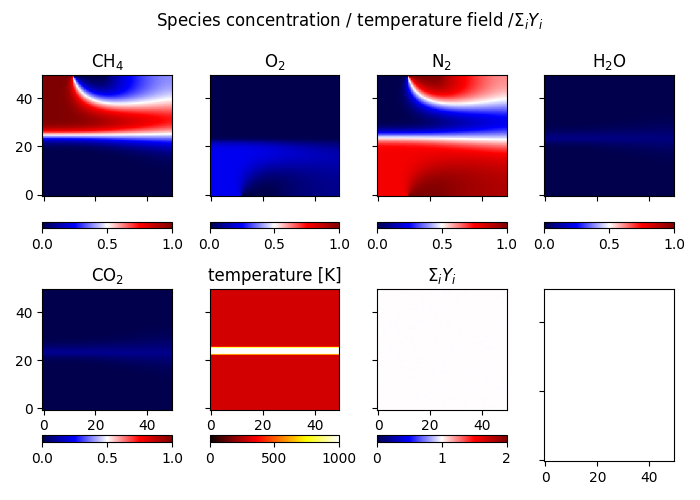

In [11]:
%autoreload 1
fig, axs =plt.subplots(2, 4, figsize=(7,5.),sharex=True, sharey=True)
plot_species_overview(Y,T, axs=axs)

For testing purposes, save the data at this step to avoid having to repeat the previous steps all the time.

In [12]:
data_sp = Path('data/species_ignited') / 'N{}M{}.npy'.format(N,M)
species_data = np.zeros((Y.shape[0] + 1, *Y.shape[1:]))
species_data[:-1,:, :] = Y
species_data[-1, :, :] = T
np.save(data_sp, species_data)

re-load the species and temperature fields if needed:

In [4]:
data_sp = Path('data/species_ignited') / 'N{}M{}.npy'.format(N,M)
species_data = np.load(data_sp)
Y = species_data[:-1,:, :]
T = species_data[-1, :, :]

Once the ignition has stabilized, add the temperature evolution:

In [5]:
Nt = 200
dt_chem = 2.2857e-7 * .5
print(dt / dt_chem, dt_chem)
_dt = 1.0 * dt

280.00175001093766 1.14285e-07


In [8]:
%time Y, T = evolve_species(Nt, Y, T, _dt, u, v, dx, dy, Ns_c, Nc_lw, chem=True, dt_chem=dt_chem, evolve_T=True);

CPU times: user 5.74 s, sys: 15.9 ms, total: 5.76 s
Wall time: 5.74 s


We see a hot spot is created in the middle of the chamber (we still need to find the stationnary state).

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
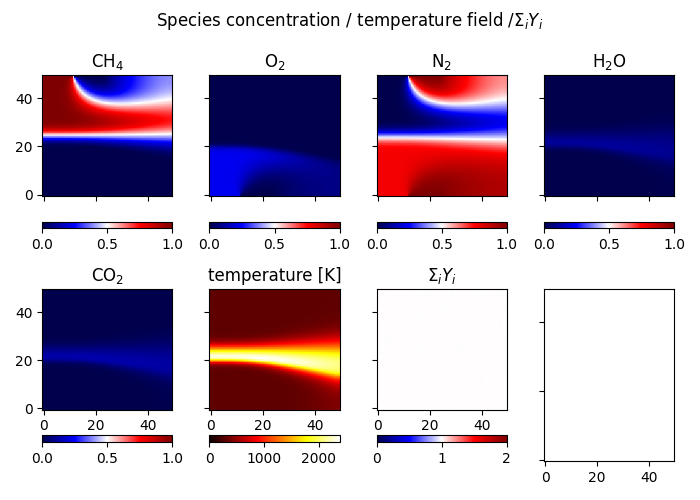

In [9]:
%autoreload 1
fig, axs =plt.subplots(2, 4, figsize=(7,5.),sharex=True, sharey=True)
plot_species_overview(Y,T, axs=axs)

Comments:
* I tested the `dt` and `dt_chem` parameters for stability in the last combustion phase
* Result: if we keep the same `dt` as before, we have for this particular case where $N,M = (50,50)$ that `dt / dt_chem` $\le$ 280 is safe. We have to check how this behaves for higher values of $N,M$.
* Alternatively, one may reduce `dt` with respect to the 'old' one, and increase `dt_chem` at the same time. I don't know yet which option is more efficient.